In [1]:
%matplotlib inline
import seaborn
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (13, 5)

[&larr; Back to Index](index.html)

# Tempo Estimation

Tempo ([Wikipedia](https://en.wikipedia.org/wiki/Tempo)) refers to the speed of a musical piece. More precisely, tempo refers to the rate of the musical beat and is given by the reciprocal of the beat period. Tempo is often defined in units of beats per minute (BPM).

In classical music, common tempo markings include grave, largo, lento, adagio, andante, moderato, allegro, vivace, and presto. See [Basic tempo markings](https://en.wikipedia.org/wiki/Tempo#Basic_tempo_markings) for more.

## Tempogram

Tempo can vary locally within a piece. Therefore, we introduce the **tempogram** (FMP, p. 317) as a feature matrix which indicates the prevalence of certain tempi at each moment in time.

### Fourier Tempogram

The **Fourier Tempogram** (FMP, p. 319) is basically the magnitude spectrogram of the novelty function.

Load an audio file:

In [16]:
x, sr = librosa.load('audio/58bpm.wav')
ipd.Audio(x, rate=sr)
print(sr)

22050


The tempo of this excerpt is about 58/116 BPM.

Compute the onset envelope, i.e. novelty function:

In [6]:
hop_length = 200 # samples per frame
onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length, n_fft=2048)

Plot the onset envelope:

In [19]:
frames = range(len(onset_env))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
print(len(onset_env), len(t), len(x))

913 913 182464


Text(0.5,1,'Novelty Function')

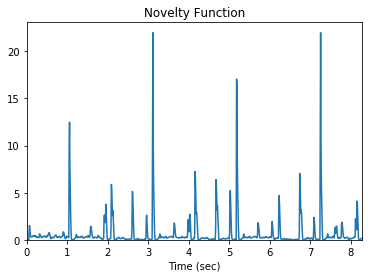

In [8]:
plt.plot(t, onset_env)
plt.xlim(0, t.max())
plt.ylim(0)
plt.xlabel('Time (sec)')
plt.title('Novelty Function')

Compute the short-time Fourier transform (STFT) of the novelty function. Since the novelty function is computed in frame increments, the hop length of this STFT should be pretty small:

In [9]:
S = librosa.stft(onset_env, hop_length=1, n_fft=512)
fourier_tempogram = numpy.absolute(S)

Plot the Fourier tempogram:

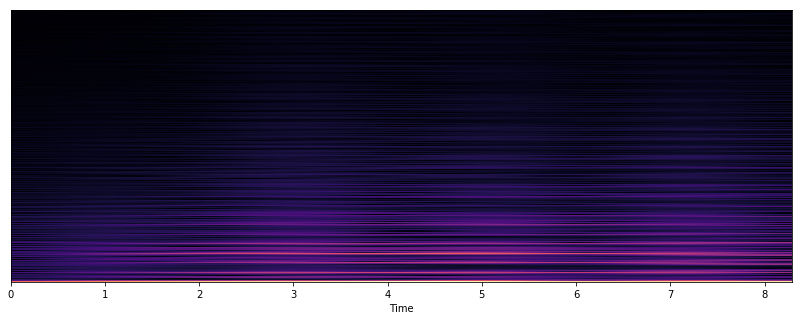

In [11]:
plt.figure(figsize=(14,5))
librosa.display.specshow(fourier_tempogram, sr=sr, hop_length=hop_length, x_axis='time')

### Autocorrelation Tempogram

Consider a segment from the above novelty function:

Text(0.5,1,'Novelty Function')

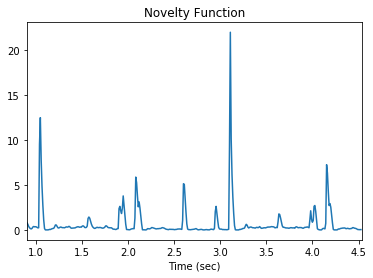

In [12]:
n0 = 100
n1 = 500
plt.plot(t[n0:n1], onset_env[n0:n1])
plt.xlim(t[n0], t[n1])
plt.xlabel('Time (sec)')
plt.title('Novelty Function')

Plot the autocorrelation of this segment:

In [13]:
tmp = numpy.log1p(onset_env[n0:n1])
r = librosa.autocorrelate(tmp)

(0, 147.32610247119595)

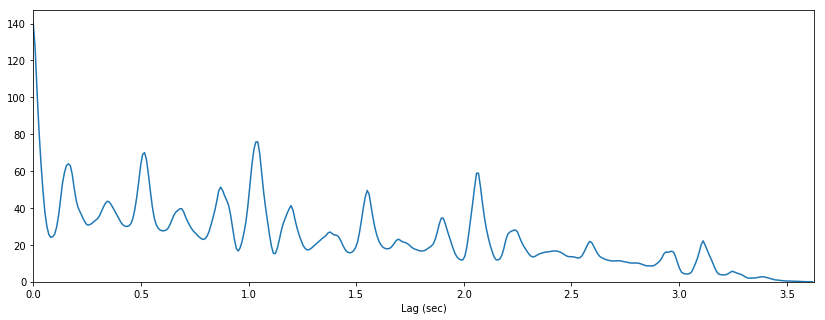

In [14]:
plt.figure(figsize=(14,5))
plt.plot(t[:n1-n0], r)
plt.xlim(t[0], t[n1-n0])
plt.xlabel('Lag (sec)')
plt.ylim(0)

Wherever the autocorrelation is high is a good candidate of the beat period.

In [67]:
t[n0], t[n1]

(0.9070294784580499, 4.535147392290249)

In [79]:
print(numpy.argsort(r)[::-1][:10])
print(t[114], t[57])
60/t[114], 60/t[57]

[  0   1   2   3 115 114 113  57 116  56]
1.034013605442177 0.5170068027210885


(58.026315789473685, 116.05263157894737)

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


(7.253289473684211, inf)

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


(0, 132.57569210358284)

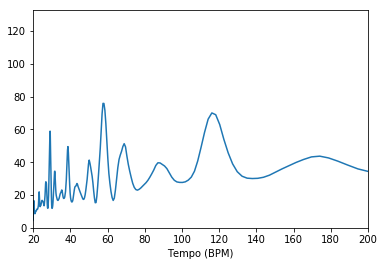

In [32]:
plt.plot(60/t[:n1-n0], r)
plt.xlim(20, 200)
plt.xlabel('Tempo (BPM)')
plt.ylim(0)

We will apply this principle of autocorrelation to estimate the tempo at every segment in the novelty function.

[`librosa.feature.tempogram`](https://librosa.github.io/librosa/generated/librosa.feature.tempogram.html#librosa.feature.tempogram) implements an **autocorrelation tempogram**, a short-time autocorrelation of the (spectral) novelty function.


For more information:
-  [Grosche, Peter, Meinard Müller, and Frank Kurth. “Cyclic tempogram - A mid-level tempo representation for music signals.” ICASSP, 2010.](http://resources.mpi-inf.mpg.de/MIR/tempogramtoolbox/2010_GroscheMuellerKurth_TempogramCyclic_ICASSP.pdf)

Compute a tempogram:

In [12]:
tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length, win_length=400)

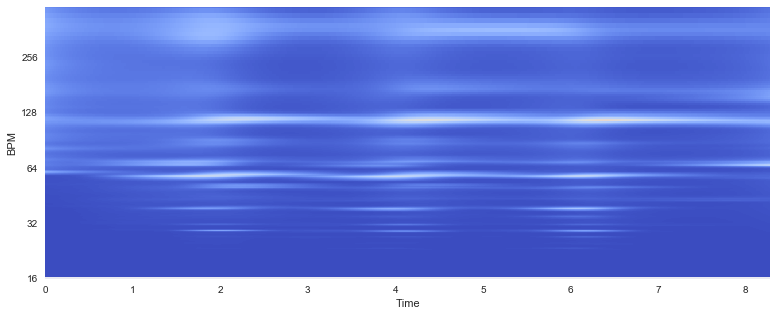

In [13]:
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo')

## Estimating Global Tempo

We will use [`librosa.beat.tempo`](https://librosa.github.io/librosa/generated/librosa.beat.tempo.html#librosa.beat.tempo) to estimate the global tempo in an audio file.

Estimate the tempo:

In [81]:
tempo = librosa.beat.tempo(x, sr=sr)
print (tempo)

[117.45383523]


Visualize the tempo estimate on top of the input signal:

In [82]:
T = len(x)/float(sr)
seconds_per_beat = 60.0/tempo[0]
beat_times = numpy.arange(0, T, seconds_per_beat)

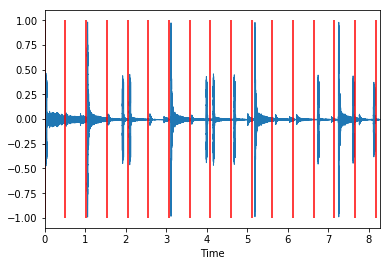

In [83]:
librosa.display.waveplot(x)
plt.vlines(beat_times, -1, 1, color='r')

Listen to the input signal with a click track using the tempo estimate:

In [84]:
clicks = librosa.clicks(beat_times, sr, length=len(x))
ipd.Audio(x + clicks, rate=sr)

[&larr; Back to Index](index.html)